## Q.1) Read the target and type of regression to be run

R-squared score: 0.9538424636384967


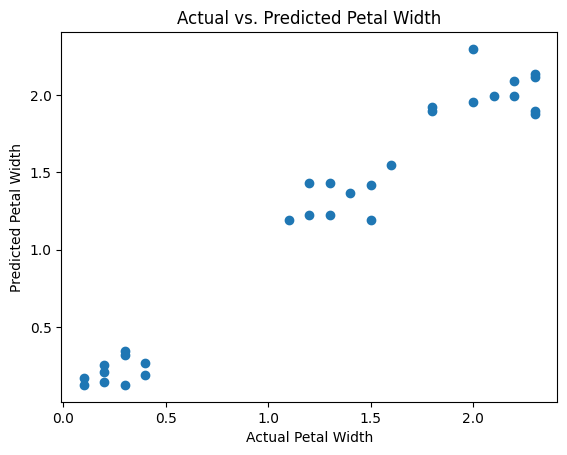

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

# Loading the data into a pandas DataFrame
data = pd.read_csv('/content/iris.csv')

# Converting categorical variables to numeric using one-hot encoding
data = pd.get_dummies(data, columns=['species'], drop_first=True)

# Assuming 'petal_width' is the target variable
X = data.drop('petal_width', axis=1)
y = data['petal_width']

# Partitioning the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating the regression model
regression_model = LinearRegression()

# Fitting the model to the training data
regression_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = regression_model.predict(X_test)

# Evaluating the model's performance
from sklearn.metrics import r2_score
r2_score_value = r2_score(y_test, y_pred)
print(f'R-squared score: {r2_score_value}')

# Visualizing the actual vs. predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Petal Width')
plt.ylabel('Predicted Petal Width')
plt.title('Actual vs. Predicted Petal Width')
plt.show()

## Q.2) Read the features (which are column names in the csv) and figure out what missing imputation needs to be applied and apply that to the columns loaded in a dataframe

In [2]:
import pandas as pd

# Loading the data into a pandas DataFrame
data = pd.read_csv('/content/iris.csv')

# Feature Handling details for "sepal_length"
sepal_length_handling = {
    "feature_name": "sepal_length",
    "is_selected": True,
    "feature_variable_type": "numerical",
    "feature_details": {
        "numerical_handling": "Keep as regular numerical feature",
        "rescaling": "No rescaling",
        "make_derived_feats": False,
        "missing_values": "Impute",
        "impute_with": "Average of values",
        "impute_value": 0
    }
}

# Checking if missing value imputation is required for "sepal_length"
if sepal_length_handling["feature_details"]["missing_values"] == "Impute":
    impute_value = sepal_length_handling["feature_details"]["impute_value"]
    data["sepal_length"].fillna(impute_value, inplace=True)

print(data.head(10))


   sepal_length  sepal_width  petal_length  petal_width      species
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa
5           5.4          3.9           1.7          0.4  Iris-setosa
6           4.6          3.4           1.4          0.3  Iris-setosa
7           5.0          3.4           1.5          0.2  Iris-setosa
8           4.4          2.9           1.4          0.2  Iris-setosa
9           4.9          3.1           1.5          0.1  Iris-setosa


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import json

# Loading the data into a pandas DataFrame
data = pd.read_csv('/content/iris.csv')

# Encoding the target variable if it contains string labels
if data["petal_width"].dtype == 'object':
    label_encoder = LabelEncoder()
    data["petal_width"] = label_encoder.fit_transform(data["petal_width"])

# One-hot encoding categorical features (if any)
categorical_columns = data.select_dtypes(include='object').columns
if len(categorical_columns) > 0:
    onehot_encoder = OneHotEncoder(drop='first', sparse_output=False)
    X_encoded = onehot_encoder.fit_transform(data[categorical_columns])

    if X_encoded.shape[1] > 0:
        column_names = [f"{col}={val}" for col, val in zip(categorical_columns, onehot_encoder.categories_[0])]
        if len(column_names) == X_encoded.shape[1]:
            X_encoded_df = pd.DataFrame(X_encoded, columns=column_names)
            data = pd.concat([data.drop(categorical_columns, axis=1), X_encoded_df], axis=1)
        else:
            X_encoded_df = pd.DataFrame(X_encoded)  # Use default column names
            data = pd.concat([data.drop(categorical_columns, axis=1), X_encoded_df], axis=1)

# Loading the JSON configuration file
with open('/content/algoparams_from_ui.json', 'r') as config_file:
    json_config = json.load(config_file)

# Feature Reduction based on the selected method
if json_config.get("feature_reduction") and json_config["feature_reduction"].get("feature_reduction_method"):
    if json_config["feature_reduction"]["feature_reduction_method"] == "No Reduction":
        # No feature reduction
        data_reduced = data.copy()
    elif json_config["feature_reduction"]["feature_reduction_method"] == "Corr with Target":
        # Feature reduction using correlation with target
        features = data.drop("petal_width", axis=1)
        target = data["petal_width"]
        corr = features.corrwith(target)
        selected_features = corr[corr > 0.5].index
        data_reduced = data[selected_features]
    elif json_config["feature_reduction"]["feature_reduction_method"] == "Tree-based":
        # Feature reduction using RandomForestRegressor
        target_column = "petal_width"
        features = data.drop(target_column, axis=1)
        target = data[target_column]
        rf = RandomForestRegressor(n_estimators=15, max_depth=20)
        rf.fit(features, target)
        importances = pd.Series(rf.feature_importances_, index=features.columns)
        selected_features = importances.nlargest(json_config["feature_reduction"]["num_of_features_to_keep"]).index
        data_reduced = data[selected_features]
    elif json_config["feature_reduction"]["feature_reduction_method"] == "PCA":
        # Feature reduction using PCA
        pca = PCA(n_components=json_config["feature_reduction"]["num_of_features_to_keep"])
        X_reduced = pca.fit_transform(data.drop("petal_width", axis=1))
        data_reduced = pd.DataFrame(X_reduced, columns=[f"PC{i}" for i in range(1, X_reduced.shape[1] + 1)])
        data_reduced['petal_width'] = data['petal_width']  # Adding the target back to the reduced data
else:
    data_reduced = data.copy()

# Preparing the data for regression
X = data_reduced.drop("petal_width", axis=1)
X.columns = X.columns.astype(str)  # Converting all column names to strings
y = data_reduced["petal_width"]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Checking if there are enough samples for training and testing
if len(X_train) == 0 or len(X_test) == 0:
    raise ValueError("No samples left after data preprocessing. Please check your data and feature reduction settings.")

# Creating the RandomForestRegressor model
regressor = RandomForestRegressor(n_estimators=15, max_depth=20)

# Fitting the model to the training data
regressor.fit(X_train, y_train)

# Making predictions on the test set
y_pred = regressor.predict(X_test)

# If the target variable was originally encoded, convert numeric predictions back to the original string labels
if data["petal_width"].dtype == 'object':
    y_pred_original = label_encoder.inverse_transform(y_pred.astype(int))
else:
    y_pred_original = y_pred

# Printing the predicted target values
print(y_pred_original)

[1.43333333 0.36       1.87333333 1.52       1.64666667 0.21333333
 1.15333333 1.94666667 1.4        1.18666667 2.04       0.18
 0.23111111 0.11333333 0.3        1.45333333 1.76666667 1.32
 1.5        1.76666667 0.2        1.77333333 0.25333333 1.76666667
 2.23333333 1.96666667 1.76666667 2.14666667 0.18       0.12      ]


## Q.4 ) Parse the Json and make the model objects (using sklean) that can handle what is required in the “prediction_type” specified in the JSON (See #1 where “prediction_type” is specified). Keep in mind not to pick models that don’t apply for the prediction_type specified

In [4]:
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression

with open("algoparams_from_ui.json", "r") as f:
    json_config = json.load(f)

prediction_type = json_config.get("prediction_type", "classification")
model_name = json_config.get("model_name", "RandomForestClassifier")
parameters = json_config.get("parameters", {})

if prediction_type == "classification":
    if model_name == "RandomForestClassifier":
        model = RandomForestClassifier(**parameters)
    elif model_name == "LogisticRegression":
        model = LogisticRegression(**parameters)
    else:
        raise ValueError("Invalid model_name")
elif prediction_type == "regression":
    model = LinearRegression(**parameters)
else:
    raise ValueError("Invalid prediction_type")

## Q.5 ) Run the fit and predict on each model – keep in mind that you need to do hyper parameter tuning i.e., use GridSearchCV

In [5]:
import json
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

with open("algoparams_from_ui.json", "r") as f:
    json_config = json.load(f)

prediction_type = json_config.get("prediction_type", "classification")
model_name = json_config.get("model_name", "RandomForestClassifier")
parameters = json_config.get("parameters", {})

if prediction_type == "classification":
    param_grid = {
        "n_estimators": [10, 20, 30],
        "max_depth": [3, 5, 7],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 3],
        "max_features": ["sqrt", "log2"]
    }
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)

    try:
        kfold = KFold(n_splits=3, shuffle=True, random_state=42)
        grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=kfold)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
    except ValueError as e:
        print(e)
else:
    raise ValueError("Invalid prediction_type")


## Q.6 ) Log to the console the standard model metrics that apply

In [9]:
import json
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

data = pd.read_csv("/content/iris.csv")

with open("algoparams_from_ui.json", "r") as f:
    json_config = json.load(f)

prediction_type = json_config.get("prediction_type", "classification")
model_name = json_config.get("model_name", "RandomForestClassifier")
parameters = json_config.get("parameters", {})

if prediction_type == "classification":
    param_grid = {
        "n_estimators": [10, 20, 30],
        "max_depth": [3, 5, 7],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 3],
        "max_features": ["sqrt", "log2"]
    }

    # Replacing class labels with numeric labels
    data['species'] = data['species'].replace({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2})

    try:
        kfold = KFold(n_splits=3, shuffle=True, random_state=42)
        grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=kfold)

        X = data.drop("species", axis=1)
        y = data["species"]

        grid_search.fit(X, y)
        best_model = grid_search.best_estimator_

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        best_model.fit(X_train, y_train)
        y_pred = best_model.predict(X_test)

        print("Accuracy:", accuracy_score(y_test, y_pred))
        print("Precision:", precision_score(y_test, y_pred, average='weighted'))
        print("Recall:", recall_score(y_test, y_pred, average='weighted'))
        print("F1 score:", f1_score(y_test, y_pred, average='weighted'))
    except ValueError as e:
        print(e)
else:
    raise ValueError("Invalid prediction_type")


Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 score: 1.0


## THE END